<a href="https://colab.research.google.com/github/Jack1Hayes/Manager-sentiment/blob/main/football_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter scrapping and sentient analysis project.
###** This project will scrape twitter using twitter API's and tweepy to get information about live tweets to generate a sentient analysis of current premier league managers.**

The first step will be to connect to twitters servers so that we can access tweets.

The docs can be found here: https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api , but lets go through, step by step.


You will have to register as a Twitter developer on the developers’ website to begin with.

Once you have regestered, you will need to create an app, any name will do but this step will allow twiiter to make sure you are who you say you are when accessing the twitter APIs.

First, go to the developer’s dashboard.

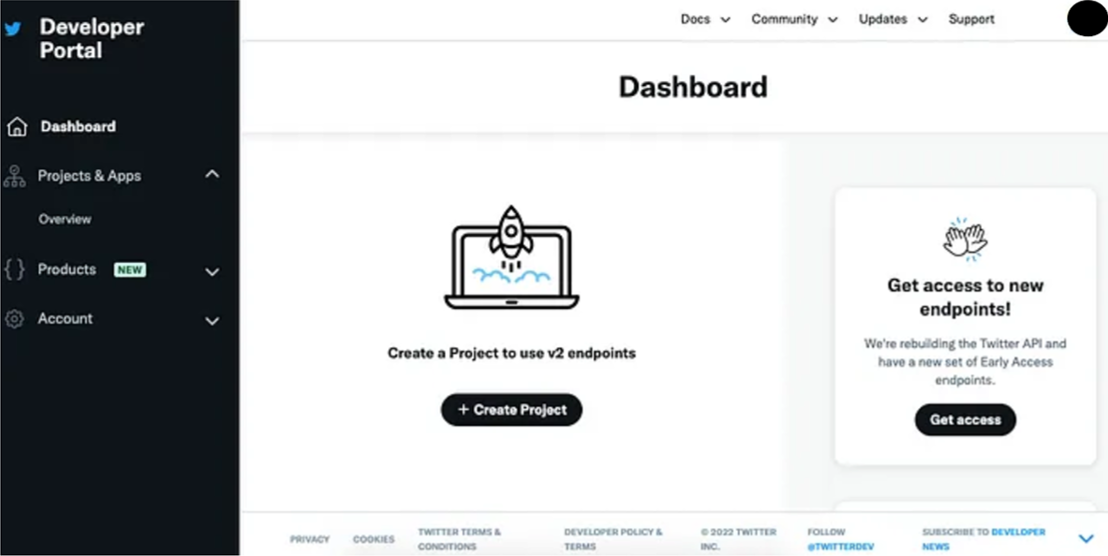

Go to the Overview tab on the left hand side and click on the Create App.


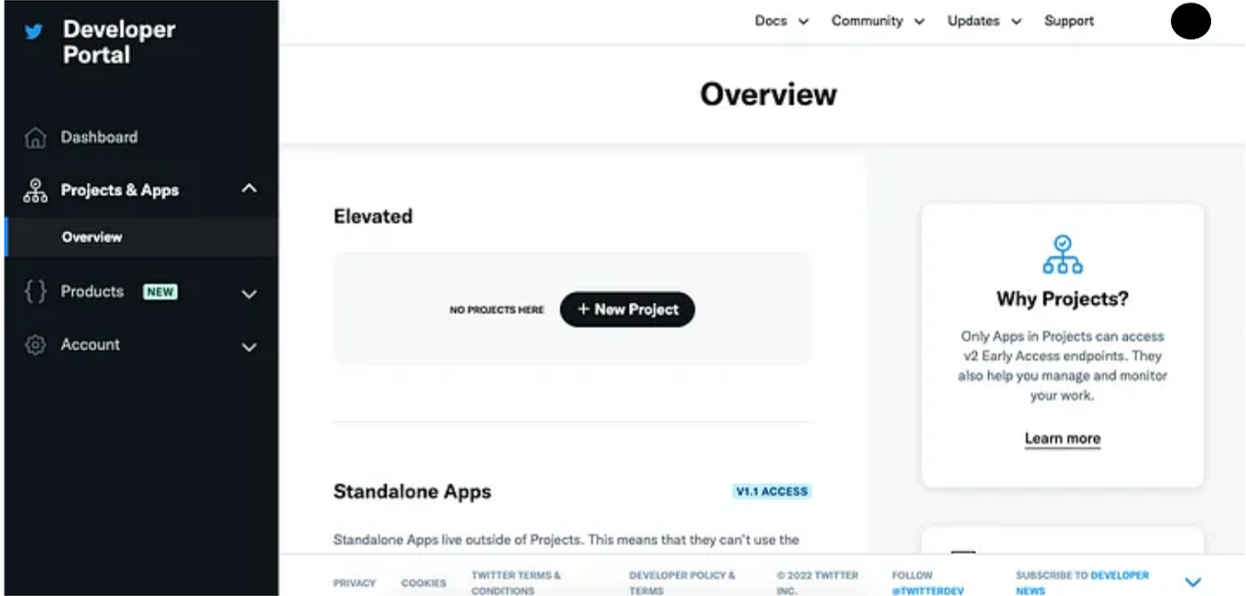

Once you give your app a name, Twitter will create your app project portal. You can go to keys and tokens at the top of the page next to settings and access the credentials needed to connect with the API. 

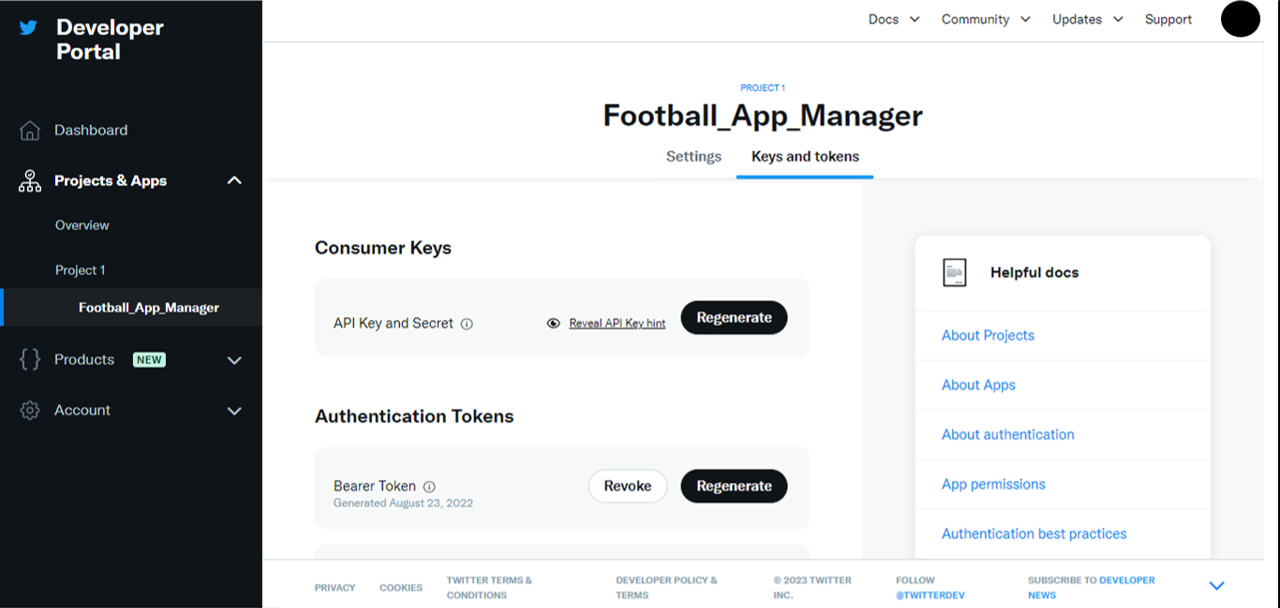

Make sure you copy all of these tokens and save them in a space only you can access. If you don't you can always regenerate the key's and tokens.

We can now use the API.

Let's first download Tweepy:


In [ ]:
!pip install tweepy==4.10.1

Before accessing Twitter, we want to get some other information. We don't want to have to manually go through every club and manager, we also want to be able to automatically change the search when a new manager is hired or one is sacked. 

Let's create some tables that contain team names, twitter handles, manager names and some other information about the team that might be useful for future ideas.

We can use beautiful soup to scrape some websites online, before using pandas to put all the data together in one place.

First the package imports:

In [ ]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import seaborn as sns; sns.set(font_scale=1.2)

Next we will access 2 websites, the first will be the wikipedia page that contains all current and old managers for each team in the premier league. It is regularly updated so is a simple way to keep on top of any changes.

The next is the Sky Sports premier league table. You can use any site you like for this. I chose this as it regularly updates the EPL table and gives a good amount of extra information we might use in the future.


In [ ]:
# get the response in the form of html, this connects us to the webpage we want to scrape.
wikiurl, EPLurl="https://en.wikipedia.org/wiki/List_of_Premier_League_managers", "https://www.skysports.com/premier-league-table"
Wikiresponse, response =requests.get(wikiurl), requests.get(EPLurl)

# finds the element on the page we want
EPLsoup = BeautifulSoup(response.text, 'html.parser')
EPLtable=EPLsoup.find('table',{'class':"standing-table__table"})

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(Wikiresponse.text, 'html.parser')
managertable=soup.find('table',{'class':"wikitable sortable plainrowheaders"})

dfEPL=pd.read_html(str(EPLtable))
# convert list to dataframe
dfEPL=pd.DataFrame(dfEPL[0])


df=pd.read_html(str(managertable))
# convert list to dataframe
df=pd.DataFrame(df[0])

Let's take a look at the tables we created using pandas.

In [ ]:
df.head()

,Name,Nat.,Club,From,Until,Duration(days),Years inLeague,Ref.
0,George Graham,NaN,Arsenal,14 May 1986,21 February 1995,3205,1992–1995,[2]
1,Stewart Houston,NaN,Arsenal,22 February 1995,8 June 1995,106,1995,[3]
2,Bruce Rioch,NaN,Arsenal,8 June 1995,12 August 1996,431,1995–1996,[2]
3,Stewart Houston,NaN,Arsenal,12 August 1996,13 September 1996,32,1996,[3]
4,Pat Rice,NaN,Arsenal,13 September 1996,30 September 1996,17,1996,[4]


In [ ]:
dfEPL.head()

,#,Team,Pl,W,D,L,F,A,GD,Pts,Last 6
0,1,Arsenal,26,20,3,3,59,25,34,63,NaN
1,2,Manchester City,26,18,4,4,66,25,41,58,NaN
2,3,Manchester United,25,15,4,6,41,35,6,49,NaN
3,4,Tottenham Hotspur,26,14,3,9,46,36,10,45,NaN
4,5,Liverpool,25,12,6,7,47,28,19,42,NaN


We have to clean some of the parts of out data, for example the Last 6 games in premier league table and nationality in the manager table both have null values, also letters that in managers names but tend not to be typed out, like 'ü', by English speakers should be replaced. We can also change & to and to make sure things match.

We also only want managers that are managing at the present time and that are in the premier league currently.

Once we clean the data in the way e like we can merge the tables.

In [ ]:
# organize data
manager_names_table = df.loc[df['Until'] == 'Present*']
manager_names = manager_names_table.drop(["Nat.", "Until", "Ref.", "Years inLeague"], axis=1)
manager_names = manager_names[~manager_names['Name'].astype(str).str.contains('§')]
manager_names = manager_names.replace(to_replace=r'&', value='and', regex=True)
manager_names = manager_names.replace(to_replace=r'ü', value='u', regex=True)
data = df.drop(["Nat.", "Ref."], axis=1)


Final_Table = pd.merge(dfEPL, manager_names, left_on=['Team'], 
             right_on= ['Club'], how='left')
Final_Table = Final_Table.drop(["Club", "Last 6"], axis=1)

Let's take a look at this table.

In [ ]:
Final_Table.head()

,#,Team,Pl,W,D,L,F,A,GD,Pts,Name,From,Duration(days)
0,1,Arsenal,26,20,3,3,59,25,34,63,Mikel Arteta,22 December 2019,1167
1,2,Manchester City,26,18,4,4,66,25,41,58,Pep Guardiola,1 July 2016,2436
2,3,Manchester United,25,15,4,6,41,35,6,49,Erik ten Hag,1 June 2022,275
3,4,Tottenham Hotspur,26,14,3,9,46,36,10,45,Antonio Conte,2 November 2021,486
4,5,Liverpool,25,12,6,7,47,28,19,42,Jurgen Klopp,8 October 2015,2703


We also need to create a table of Twitter handles for the teams in the league. There is no online resource for this that I could find, So i had to manually write it. The handles won't change but the teams will need to be updated every season due to promotion and relegation.

This table will be the one we use to get the tweets from the twitter API.

We will also split the names of the manager to make the search a little more robust when going through tweets.

In [ ]:
Single_manager_names = manager_names
Single_manager_names.loc[Single_manager_names['Name'].str.split().str.len() >= 2, 'last name'] = Single_manager_names['Name'].str.split().str[-1]
First_Single_manager_names = manager_names
First_Single_manager_names.loc[Single_manager_names['Name'].str.split().str.len() >= 2, 'first name'] = Single_manager_names['Name'].str.split().str[0]

Team_Twitter = pd.DataFrame({'Club': manager_names['Club'],
                'Twiiter name': ['Arsenal', 'AVFCOfficial', 'afcbournemouth', 'Brentfordfc', 'OfficialBHAFC',
                'ChelseaFC', 'CPFC', 'Everton', 'FulhamFC', 'LUFC', 'LCFC', 'LFC', 'ManCity', 
                'ManUtd', 'NUFC', 'NFFC', 'SouthamptonFC', 'SpursOfficial', 'WestHam', 'Wolves']})


Twitter_table = pd.merge(Single_manager_names, Team_Twitter, left_on=['Club'], 
             right_on= ['Club'], how='left')
Twitter_table = pd.merge(First_Single_manager_names, Team_Twitter, left_on=['Club'], 
             right_on= ['Club'], how='left')

In [ ]:
Twitter_table.head()

,Name,Club,From,Duration(days),last name,first name,Twiiter name
0,Mikel Arteta,Arsenal,22 December 2019,1167,Arteta,Mikel,Arsenal
1,Unai Emery,Aston Villa,1 November 2022,122,Emery,Unai,AVFCOfficial
2,Gary O'Neil,Bournemouth,30 August 2022[a],185,O'Neil,Gary,afcbournemouth
3,Thomas Frank,Brentford,16 October 2018,1599,Frank,Thomas,Brentfordfc
4,Roberto De Zerbi,Brighton and Hove Albion,18 September 2022[b],166,Zerbi,Roberto,OfficialBHAFC


Now let's get the data from Twitter. 

First the imports.

In [ ]:
import tweepy
from datetime import datetime, timedelta

The first thing is to imput the keys and tokens we received earlier.

In [ ]:
api_key= 'kkNqG6QlAJfAUwkaHANj0EGv4' 
api_secret= 'UXlRuPxuBI81iKB3oWU8lzj2g5d22eRm2rkK7klzYaQFHUFkd9'
access_token= '1436025732-uQbqEAxbG4MYFyCksAeK5EvYx6iJldguIvBzeoK'
access_token_secret= '96l7QHPdFgfYYI8l6y7PDQ1jNTeHjKCjUiAMKKhWIiZ4u'
bearer_token= 'AAAAAAAAAAAAAAAAAAAAALAcfwEAAAAAws5L8IRN6AdaSwFRJ1buXqVK1L4%3DiONfYZq9Uv95GaqyIjrki37dEwTKwD1UD1NBu6FoR4Fk5iKPTw'


And to use these keys to access the API.

In [ ]:
client = tweepy.Client(bearer_token)
# Authenticating the APIs
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Here is the basic set up for accessing tweets. Take a look at the documentation to see how to phrase your querys, as they have a specific language to request replys, original tweets, retweets and other forms. 

Also, with your current level you will be only able to access tweets from the last 7 days.

In [ ]:
query = "Enter Query"
print(query)
# your start and end time for fetching tweets
start_time = "Tweets from when"
end_time = "Tweets until when"
# get tweets from the API, you can aso input the types of information you want from your tweets. Check the documentation to see what ype of information you can access.
tweets = client.search_recent_tweets(query=query,
                                      start_time=start_time,
                                      end_time=end_time,
                                      tweet_fields = ["created_at", "text", "source","public_metrics"],
                                      user_fields = ["verified"],
                                      max_results = 100,
                                      expansions='author_id'
                                      )


# create a list of records
tweet_info_ls = []
# iterate over each tweet and corresponding user details. Again here you can access different infmation about each tweet.
for tweet, user in zip(tweets.data, tweets.includes['users']):
    tweet_info = {
        'created_at': tweet.created_at,
        'text': tweet.text,
        'source': tweet.source,
        'verified': user.verified,
        'like count': tweet.public_metrics['like_count'],
        'reply_count': tweet.public_metrics['reply_count'],
        'retweet_count': tweet.public_metrics['retweet_count'],
        'quote_count': tweet.public_metrics['quote_count'],
    }
    tweet_info_ls.append(tweet_info)
# create dataframe from the extracted records
tweets_df = pd.DataFrame(tweet_info_ls)
# display the dataframe
tweets_df.head()

The edits made first cycle, first create a file in the computer with headers: 'created_at', 'text', 'source', 'verified',  'like_count',  'reply_count', 'retweet_count', 'quote_count'. Choose your file location and data you would like to access. It does this for every club in the twitter table.

Once the file is created, the query searches tweets that are in response to any tweet from the official club account that contain the names of the manager, either first or second name, over the past week.

Finally we save all the data in the file we created at the beggining.

In [ ]:
def get_tweets():

    for i in Twitter_table.index:
        headers = pd.DataFrame(columns=['created_at','text', 'source','verified', 'like_count', 'reply_count','retweet_count','quote_count'])
        headers.to_csv(r'/content/sample_data/'+str(Twitter_table['Club'][i][:3])+str(Twitter_table['Club'][i][-1])+'.csv',mode='w+',  index = False)
        for j in range(6):
            try:
                query = "("+(str(Twitter_table['last name'][i])+ " OR " + str(Twitter_table['first name'][i]) + ") lang:en -is:retweet to:"+str(Twitter_table['Twiiter name'][i])+" @"+str(Twitter_table['Twiiter name'][i]))
                print(query)
                # your start and end time for fetching tweets
                start_time = (datetime.today()-timedelta(days=(6-j))).strftime('%Y-%m-%dT00:00:00Z')
                end_time = (datetime.today()-timedelta(days=(5-j))).strftime('%Y-%m-%dT00:00:00Z')
                # get tweets from the API
                tweets = client.search_recent_tweets(query=query,
                                                     start_time=start_time,
                                                     end_time=end_time,
                                                     tweet_fields = ["created_at", "text", "source","public_metrics"],
                                                     user_fields = ["verified"],
                                                     max_results = 100,
                                                     expansions='author_id'
                                                     )

                
                # create a list of records
                tweet_info_ls = []
                # iterate over each tweet and corresponding user details
                for tweet, user in zip(tweets.data, tweets.includes['users']):
                    tweet_info = {
                        'created_at': tweet.created_at,
                        'text': tweet.text,
                        'source': tweet.source,
                        'verified': user.verified,
                        'like count': tweet.public_metrics['like_count'],
                        'reply_count': tweet.public_metrics['reply_count'],
                        'retweet_count': tweet.public_metrics['retweet_count'],
                        'quote_count': tweet.public_metrics['quote_count'],
                    }
                    tweet_info_ls.append(tweet_info)
                # create dataframe from the extracted records
                tweets_df = pd.DataFrame(tweet_info_ls)
                # display the dataframe
                tweets_df.head()
                #saving to csv pd.DataFrame(columns=['A','B','C','D','E','F','G'])
                                
                tweets_df.to_csv(r'/content/sample_data/'+str(Twitter_table['Club'][i][:3])+str(Twitter_table['Club'][i][-1])+'.csv' ,mode='a',header = False, index = False)
            except KeyError:
                pass
        
get_tweets()

(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Arteta OR Mikel) lang:en -is:retweet to:Arsenal @Arsenal
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(Emery OR Unai) lang:en -is:retweet to:AVFCOfficial @AVFCOfficial
(O'Neil OR Gary) lang:en -is:retweet to:afcbournemouth @afcbournemouth
(O'Neil OR Gary) lang:en -is:retweet to:afcbournemouth @afcbournemouth
(O'Neil OR Gary) lang:en -is:retweet to:afcbournemouth @afcbournemouth
(O'Neil OR Gary) lang:en -is:retweet to:afc

We now have our tweets so let's analyse them using sentiment analysis. Here I'm going to use Vader to use it's sentiment analysis feature. You will have to go into its dictionary to get the best results as the words used here and sarcastic manner of some comments do not work well with Vader's analysis.

Let's import the packages

In [ ]:
!pip install vaderSentiment

In [ ]:
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

We next want to create the sentiment analyzer object that will do the analysis of each of the tweets we stored earlier.

Using the analyser we can analyse all the tweets and put the scores of the analysis into an array that we can find an average of later.

We want to do this for all of our sheets so lets create a function that we can cycle through for each one of the csv files we created.

In [ ]:

def sentiment_scores(text_data):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()


    neg_score_vad=[]
    neu_score_vad=[]
    pos_score_vad=[]

        
    for tweets in df:
        sentiment_dict = sid_obj.polarity_scores(tweets)
        
        neg_score_vad.append(sentiment_dict['neg']*100)
        neu_score_vad.append(sentiment_dict['neu']*100)
        pos_score_vad.append(sentiment_dict['pos']*100)
        score_textblob.append(Text_sid_obj)
        pol_textblob.append(Text_pol_obj)
        
        
    text_data['neg score'] = neg_score_vad
    text_data['neu score'] = neu_score_vad
    text_data['pos score'] = pos_score_vad
    
    return


The next part we want to cycle through each of the csv files full of tweets, and create an average for them, adding those averages to an array to add to our table later.

In [ ]:
negarray = []
neuarray = []
posarray = []
ave_text = []
ave_text_pol = []
time = (datetime.now()-timedelta(days=21))

for i in Twitter_table.index:
    try:
        anal_data = pd.read_csv(r'/content/sample_data/'+str(Twitter_table['Club'][i][:3])+str(Twitter_table['Club'][i][-1])+'.csv')
        if datetime.strptime(anal_data['created_at'][i][:19], '%Y-%m-%d %H:%M:%S') > time:
            df = anal_data['text']
            text_data = pd.DataFrame(df, columns = ['text'])
            
                
            sentiment_scores(text_data)
            
            ave_neg = np.average(text_data['neg score'])
            negarray.append(ave_neg)
            ave_neu = np.average(text_data['neu score'])
            neuarray.append(ave_neu)
            ave_pos = np.average(text_data['pos score'])
            posarray.append(ave_pos)
    except:
                
                
            negarray.append(0)
            neuarray.append(0)
            posarray.append(0)

Let's finally create a table with all the information we have collected.

In [ ]:
scores_data = {'Team': Twitter_table['Club'],
                'negative score': negarray,
                'neutral score': neuarray,
                'positive score': posarray}
scores_table = pd.DataFrame(scores_data)
#print(scores_table)
Final_Table_Data = pd.merge(scores_table, Final_Table, left_on=['Team'], 
             right_on= ['Team'], how='left')

In [ ]:
Final_Table_Data.head()

,Team,negative score,neutral score,positive score,#,Pl,W,D,L,F,A,GD,Pts,Name,From,Duration(days)
0,Arsenal,5.771004,77.381784,16.846468,1,26,20,3,3,59,25,34,63,Mikel Arteta,22 December 2019,1167
1,Aston Villa,5.133333,79.720370,15.144444,11,25,10,4,11,31,38,-7,34,Unai Emery,1 November 2022,122
2,Bournemouth,12.941379,77.848276,9.213793,20,25,5,6,14,24,51,-27,21,Gary O'Neil,30 August 2022[a],185
3,Brentford,0.000000,0.000000,0.000000,9,23,8,11,4,37,30,7,35,Thomas Frank,16 October 2018,1599
4,Brighton and Hove Albion,4.726316,84.578947,10.700000,8,23,11,5,7,43,29,14,38,Roberto De Zerbi,18 September 2022[b],166


###Summary and additions

There are a few things that you might want to add to the dictionary for vader as the language football fans use on twitter isn't suitable for an accurate analysis.

You could of course design your own sentient analysis model but for a first step it is enough.

Also there are some clubs that have no tweets about their manager, and as you can't go back further than a week not all of the data will be avaliable.

Overall a successful project where, if enough data is collected I would like to build a model to predict manager sacking liklihood.

A next step might be to automate this process.